In [1]:
import numpy as np
import matplotlib.pyplot as pp

In [2]:
# Generate clusters

D= 2 # dim of the data
M= 200 # number of data
L = 15 # taille du cube
Nc = 3 # nb de clusters

centers = np.array([])
var = np.array([])
for c in range(Nc):
    m = np.random.uniform(2*L,size=(D))-L
    centers = np.append(centers,[m])
    var = np.append(var,(np.random.random()*3+0.5))
    
centers = centers.reshape(Nc,D)
ch = [c for c in range(Nc)]
data_lab = np.random.choice(ch,size=(M))
data = np.zeros((D,M))
for i in range(Nc):
    idx = np.where(data_lab==i)
    data[:,idx[0]] = centers[i].reshape(D,1) + var[i]*np.random.normal(size=(D,len(idx[0])))


In [3]:
# Print propeties of the clusters
print(centers)
print(var)

[[  6.84851399  14.37368812]
 [ -1.03055726   2.93127166]
 [-12.33986676 -10.29285556]]
[1.41790831 1.64118448 3.36274844]


In [4]:
# center the dataset
data = data - np.mean(data,1).reshape(2,1)

In [5]:
# gaussian distribution
def gauss(x,m,σ):
    return 1/np.sqrt(2*np.pi*σ)*np.exp( -(x-m)**2/(2*σ))

In [6]:
# init randomly the centers
def initMeans(K,L,D):
    μ  = np.array([])
    for c in range(K):
        m = np.random.uniform(2*L,size=(D))-L
        μ = np.append(μ,[m])
    μ = μ.reshape(D,K)
    return μ

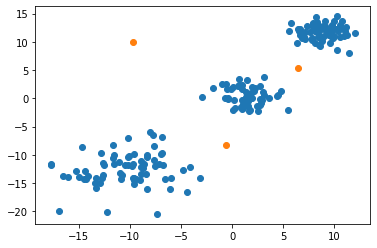

In [8]:
# Showing the datapoint and the initial position of the centers
pp.scatter(data[0,:],data[1,:])
# pp.scatter(μ[0,:],μ[1,:])

In [9]:
# compute r_i^a : the probability that data i is in the cluster a
# X is DxM
# μ is DxC
def ComputeResp(X,μ,σ,ρ):
    Resp = np.zeros((X.shape[1],μ.shape[1]))
    for i in range(X.shape[1]):
        for c in range(μ.shape[1]):
            tmp = 1.0
            for d in range(X.shape[0]):
                tmp *= gauss(X[d,i],μ[d,c],σ[d,c])
                
            Resp[i,c] = ρ[c]*tmp
        Resp[i,:] = Resp[i,:] / np.sum(Resp[i,:])
    return Resp  

In [10]:
# update the position of the centers
def UpdateMeans(X,μ,P):
    return np.matmul(X,P)/np.sum(P,0)

In [11]:
# update the position of the variances (I guess it can be improved)
def UpdateVar(X,μ,σ,P):
    Xtmp = np.zeros(σ.shape)
    for c in range(μ.shape[1]):
        for d in range(X.shape[0]):
            for i in range(X.shape[1]):
                Xtmp[d,c] += P[i,c]*(X[d,i] - μ[d,c])**2
    return Xtmp/np.sum(P,0)

In [12]:
# update the density
def UpdateRho(P):
    return np.sum(P,0)/np.sum(P)

In [13]:
# compute the likelihood
def ComputeLikelihood(X,μ,σ,ρ):
    Like = 0
    for i in range(X.shape[1]):
        Like_i = 0
        for c in range(μ.shape[1]):
            tmp = 1
            for d in range(μ.shape[0]):
                tmp *= gauss(X[d,i],μ[d,c],σ[d,c])
            Like_i += ρ[c]*tmp
        Like += np.log(Like_i)
    return Like/X.shape[1]

In [14]:
# function (took from scikit-learne example) to plot ellipses
import matplotlib as mpl
colors = ['navy', 'turquoise', 'darkorange', 'red']

def make_ellipses(ax, μ, σ, nc):
    for n,col in enumerate(colors[0:nc]):
        covariances = np.diag(σ[n,:])
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(μ[n, :], v[0], v[1],
                                  180+angle, color=col)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

In the next cell, we initiate randomly the centers, the variances and the densities of all the gaussian distributions. Then the code is runned for 20 iteration (in practice, you should put a stopping criterion).
The scatter position of the centers is updated at each iteration.

[[3.27017565 1.40044452 1.62678545]
 [2.80141375 1.23943111 1.62484055]]
[[-10.34108298   8.91583144   1.4315344 ]
 [-12.53291816  11.74514913   0.4053717 ]]


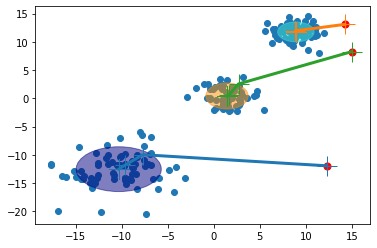

In [41]:
μ = initMeans(K,L,D)
σ = np.ones(μ.shape)
ρ = np.ones(K)/K

f = pp.subplot()

pp.scatter(data[0,:],data[1,:])
pp.scatter(μ[0,:],μ[1,:],s=50,color='red')

like = np.array([])
itmax = 20
centers_pos = np.zeros((itmax+1,D,K))
centers_pos[0,:,:] = 1.0*μ

for i in range(itmax):
    Resp = ComputeResp(data,μ,σ,ρ)
    μ = UpdateMeans(data,μ,Resp)
    σ = UpdateVar(data,μ,σ,Resp)
    ρ = UpdateRho(Resp)
    # pp.scatter(μ[0,:],μ[1,:])
    centers_pos[i+1,:,:] = 1.0*μ
    like = np.append(like,ComputeLikelihood(data,μ,σ,ρ))

for k in range(K):
    pp.plot(centers_pos[:,0,k],centers_pos[:,1,k],'-+',linewidth=3, markersize=20)
    
print(np.sqrt(σ))
print(μ)
make_ellipses(f,μ.T,σ.T,3)




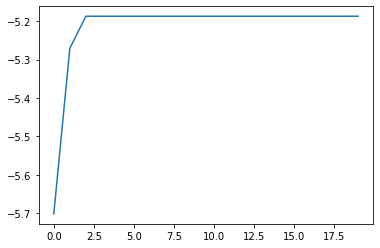

In [43]:
pp.plot(like)

In [44]:
for c in range(Nc):
    id_ = np.where(data_lab==c)
    print("mean=",np.mean(data[:,id_[0]],1)," *** Var=",np.std(data[:,id_[0]],1))

mean= [ 8.91583144 11.74514913]  *** Var= [1.40044452 1.23943111]
mean= [1.43153144 0.40537038]  *** Var= [1.62678812 1.62484057]
mean= [-10.34109062 -12.53292798]  *** Var= [3.27016587 2.80139408]


Now we run the algorithm for many different number of clusters and plot the obtained likelihood.

In [45]:

like = np.array([])
for K in np.arange(1,7):    
    l = np.nan
    while(np.isnan(l)):
        μ = initMeans(K,L,D)
        σ = np.ones(μ.shape)
        ρ = np.ones(K)/K

        for i in range(50):
            Resp = ComputeResp(data,μ,σ,ρ)
            μ = UpdateMeans(data,μ,Resp)
            σ = UpdateVar(data,μ,σ,Resp)
            ρ = UpdateRho(Resp)
            
        l = ComputeLikelihood(data,μ,σ,ρ)
    like = np.append(like,l)



/home/aurele/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aurele/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


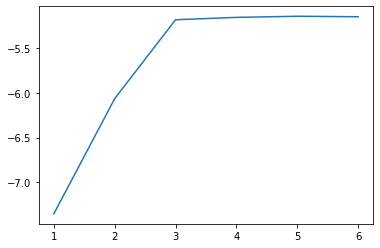

In [46]:
pp.plot(np.arange(1,7),like)